# Байесовский выбор моделей
## Домашняя работа №3
### Никитина Мария, Б05-003

# Задача 1

Пусть имеется обучающая и тестовая выборки $(X_{train}, y_{train}), X_{train} \in \mathbb{R}^{m_1 \times n}, y_{train} \in [−1, 1]^{m_1}, (X_{test}, y_{test}), X_{test} \in \mathbb{R}^{m_2 \times n}, y_{test} \in [−1, 1]^{m_2}$, полученные из общей модели
генерации данных с совместным правдоподобием

$$p(y, w, X|\alpha) = \prod\limits_i N(x_i|0, \sigma^2I_n) N(w|0, A^{-1})\prod\limits_i p(y_j|x_j, w),$$

где $P(y_j|x_j, w)$ дается моделью логистической регрессии, то есть

$$P(y_j = 1) = \frac{1}{1 + \exp(−w^{\top}x_j)}.$$

а) Выписать формулу для апостериорного распределения $p(w|X_{train}, y_{train}, A)$ и получить его нормальную аппроксимацию $p(w|X_{train}, y_{train}, A) \approx N(w_0, H_0^{-1})$ (4 балла);


$$P(w|X_{train}, y_{train}, A) = \frac{P(w, y_{train}|X_{train}, A)}{P(y_{train}|X_{train}, A)}$$

Рассмотрим логарифм выражения. Нас интересует больше числитель, так как в знаменателе константа.

$$−\log{P(w, y_{train}|X_{train}, A)} = − \log{(P(y_{train}|X_{train}, w)P(w|A))} = − \log{P(w|A)}- \log{P(y_{train}|X_{train}, w)} =\\= -\log{\left(\frac{1}{(2\pi)^{n/2}|A^{-1}|^{1/2}}\exp{\left(-\frac{1}{2}w^TAw\right)}\right)} - \sum_{i=1}^{m_1}{\log{\sigma(y_iw^Tx_i)}} =\\= \frac{n}{2}\log{2\pi} + \frac{1}{2}\log{|A^{-1}|} + \frac{1}{2}w^TAw + \sum_{i=1}^{m_1}{\log{(1+\exp(−y_iw^Tx_i))}}$$

Применим аппроксимацию Лапласа:

$$−\log{P(y_{train}, w|X_{train}, A)} = \frac{n}{2}\log{2\pi} + \frac{1}{2}\log{|A^{-1}|} + \frac{1}{2}w_0^TAw_0 + \sum_{i=1}^{m_1}{\log{(1+\exp(−y_iw_0^Tx_i))}} +\\+ \frac{1}{2}(w − w_0)^T(A + X_{train}^T\text{diag}\left(\sigma(w^T_0x_j)\sigma(-w^T_0x_j)\right)X_{train})(w − w_0)+ O\left(\|w-w_0\|^3\right)$$

Обозначим $H_0^{-1} = A + X_{train}^T(\text{diag}\left(\sigma(w^T_0x_j)\sigma(-w^T_0x_j)\right)X_{train}$

Тогда нормальная аппроксимация:

$$P(w|X_{train}, y_{train}, A) \sim N(w|w_0, H_0^{−1})$$

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm

In [4]:
def func(w):
    sum_m1 = 0
    for i, x_i in enumerate(X_train):
        sum_m1 += np.log(sigmoid(-y_train[i] * (w @ x_i)))

    norm_distribution = scipy.stats.multivariate_normal(cov=A)
    return - np.log(norm_distribution.pdf(w)) - sum_m1

def sigmoid(val):
    return 1 / (1 + np.exp(-val))

def hess(X_train, X_test, w_0, num_experiments = 5000):
    sum_list = 0

    R = np.diag([sigmoid(w_0 @ x) * sigmoid(- w_0 @ x) for x in X_train])
    H = A + X_train.T @ R @ X_train
    norm_distribution = scipy.stats.multivariate_normal(mean=w_0, cov=H)

    for i in range(num_experiments):
        w = norm_distribution.rvs()
        sum_list += sigmoid(X_test @ w)

    return sum_list / num_experiments

def C(p):
    return np.sum(np.abs(p - 0.5))

def l(y, p):
    result_log = 0
    for i, y_i in enumerate(y):
        result_log += np.log(p[i]) * y_i + np.log(1 - p[i]) * (1 - y_i)

    return result_log

In [5]:
m1_list = [100 * i for i in range(1, 51)]
n = 20
m2 = 1000
A = np.eye(n)

C_1, C_2 = [], []
l_1, l_2 = [], []

X_test = np.random.randn(m2, n)
w = np.random.randn(n)
y_prob = np.array([sigmoid(x @ w) for x in X_test])
y_test = np.random.binomial(n=1, p=y_prob, size=m2)
y_test = np.array([1. if i == 1 else -1. for i in y_test])

for m1 in tqdm.tqdm(m1_list):
    X_train = np.random.randn(m1, n)
    w = np.random.randn(n)
    y_prob = np.array([sigmoid(x @ w) for x in X_train])
    y_train = np.random.binomial(n=1, p=y_prob, size=m1)
    y_train = np.array([1. if i == 1 else -1. for i in y_train])

    w_0 = np.zeros(n)
    result = scipy.optimize.minimize(func, w_0, method='powell', options={'xtol': 1e-8})

    w_map = result.x

    model_1 = sigmoid(X_test @ w_map)
    model_2 = hess(X_train, X_test, w_map)

    C_1.append(C(model_1))
    C_2.append(C(model_2))

    l_1.append(l(y_test, model_1))
    l_2.append(l(y_test, model_2))

100%|██████████| 50/50 [24:32<00:00, 29.45s/it]


Text(0, 0.5, '$\\log(C)$')

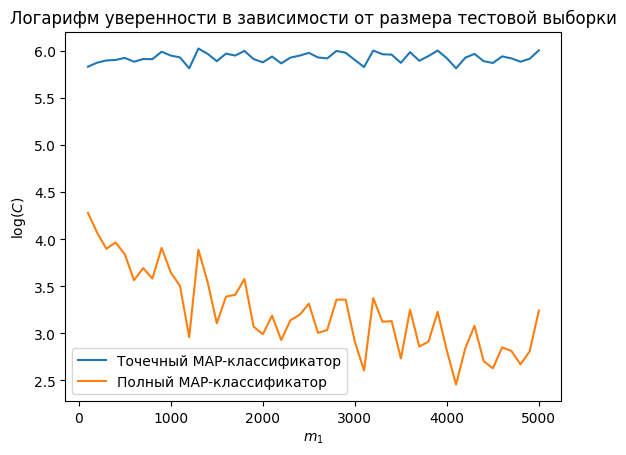

In [7]:
plt.plot(m1_list, np.log(C_1), label="Точечный MAP-классификатор")
plt.plot(m1_list, np.log(C_2), label="Полный MAP-классификатор")
plt.title("Логарифм уверенности в зависимости от размера тестовой выборки")
plt.legend()
plt.xlabel(r"$m_1$")
plt.ylabel(r"$\log(C)$")

Text(0, 0.5, '$\\log l$')

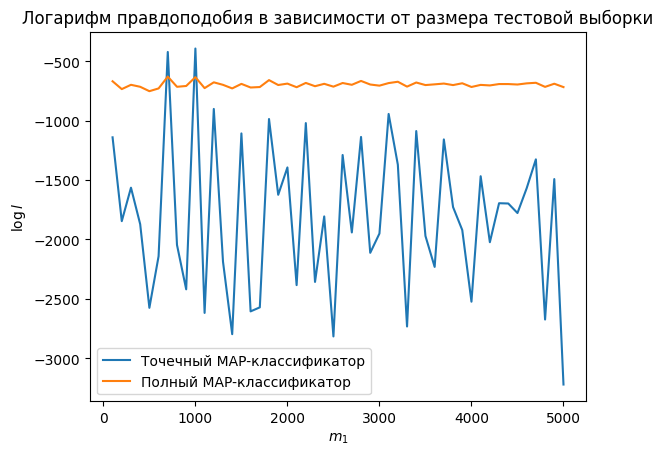

In [8]:
plt.plot(m1_list, l_1, label="Точечный MAP-классификатор")
plt.plot(m1_list, l_2, label="Полный MAP-классификатор")
plt.title("Логарифм правдоподобия в зависимости от размера тестовой выборки")
plt.legend()
plt.xlabel(r"$m_1$")
plt.ylabel(r"$\log l$")

Размер выборки практически не влияет на правдоподобие и уверенность модели (только уверенность полного MAP-классификатора немного уменьшается с ростом числа элементов в выборке). Таким образом, для экономии времени и ресурсов можно брать подвыборку и на ней всё считать. И лучше брать полную модель, так как флуктуации её правдоподобия гораздо меньше, чем у точечной, хотя уверенность скачет сильнее (здесь берём за основу то, что правдоподобие обычно информативнее уверенности).

# Задача 2

Пусть имеется модель линейной регрессии с нормальным шумом $\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{\varepsilon}$, $\mathbf{\varepsilon} \sim N(0, \sigma^2\mathbf{I})$, где $\sigma^2$ – известно, и априорным распределением на $\mathbf{w}$ $p(\mathbf{w}) = N(\mathbf{w}|\mathbf{m}, \text{diag}(\mathbf{s}))$, где $\mathbf{m}$ и $\text{diag}(\mathbf{s})$ неизвестные гиперпараметры.

а) Выписать совместное правдоподобие $p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \mathbf{m}, \mathbf{s})$, задающее вероятностную модель. (2 балла)

$$p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \mathbf{m}, \mathbf{s}) = p(\mathbf{w}|\mathbf{X},\mathbf{m},\mathbf{s})p(\mathbf{y}|\mathbf{w}, \mathbf{X},\mathbf{m},\mathbf{s}) = p(\mathbf{w}|\mathbf{m},\mathbf{s})p(\mathbf{y}|\mathbf{w}, \mathbf{X}) =\\= \frac{1}{(2\pi)^{n/2}|\text{diag}(\mathbf{s})|^{1/2}}\exp{\left(-\frac{1}{2}(\mathbf{w}-\mathbf{m})^T\text{diag}(\mathbf{s})^{-1}(\mathbf{w}-\mathbf{m})\right)} \cdot \frac{1}{(2\pi)^{n/2}\sigma^n}\exp{\left(-\frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)} =\\= \frac{1}{(2\pi)^n|\text{diag}(\mathbf{s})|^{1/2}\sigma^n}\exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}$$

б) Получить апостериорное распределение на вектор $\mathbf{w}$, предполагая $\mathbf{m}$ и $\mathbf{s}$ известными. Что происходит, если $s_i = 0$? (4 баллов)

$$p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \mathbf{m}, \mathbf{s}) = \frac{p(\mathbf{y}|\mathbf{w}, \mathbf{X})p(\mathbf{w}| \mathbf{m}, \mathbf{s})}{\int p(\mathbf{y}|\mathbf{w}, \mathbf{X})p(\mathbf{w}| \mathbf{m}, \mathbf{s})d\mathbf{w}} =\\= \frac{\frac{1}{(2\pi)^n|\text{diag}(\mathbf{s})|^{1/2}\sigma^n}\exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}}{\int \frac{1}{(2\pi)^n|\text{diag}(\mathbf{s})|^{1/2}\sigma^n}\exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}d\mathbf{w}} =$$

$$= \frac{\exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}}{\int \exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}d\mathbf{w}}$$

Если $s_i = 0$, то признак не вносит вклад в правдоподобие и апостериорное распределение. Его можно убрать из рассмотрения.

в) Решить задачу максимизации обоснованности $p(\mathbf{y}|\mathbf{X}, \mathbf{m}, \mathbf{s}) = \int p(\mathbf{y}|\mathbf{X}, \mathbf{w})p(\mathbf{w}|\mathbf{m}, \text{diag}(\mathbf{s}))d\mathbf{w}$ по гиперпараметрам $\mathbf{m}$ и $\mathbf{s}$. Какой вывод можно сделать из полученного результата? (14 баллов)


$$p(\mathbf{y}|\mathbf{X}, \mathbf{m}, \mathbf{s}) = \int \frac{1}{(2\pi)^n|\text{diag}(\mathbf{s})|^{1/2}\sigma^n}\exp{\left(-\frac{1}{2}\sum_{i = 1}^n(w_i - m_i)^2s_i - \frac{1}{2\sigma^2}||\mathbf{Xw}-\mathbf{y}||^2\right)}d\mathbf{w}$$

# Задача 3

Пусть имеется две двухсторонние монеты, случайно и независимо выбранные из всех существующих монет достоинством в 2 рубля. Пусть было произведено $n_1 = 10$ бросаний первой монеты и $n_2 = 10000$ бросаний второй. Среди $n_1 = 10$ результатов бросания первой монеты было $k_1 = 3$ орла, а среди $n_2 = 10000$ бросаний второй – $k_2 = 5100$ орлов.

а) Построить вероятностную модель эксперимента, записав правдоподобие и введя априорные распределения на вероятности $p_1$ и $p_2$ выпадания орлов для первой и второй монеты соответственно. Опишите, как и из каких соображений Вы выбрали априорные распределения $q(p_1)$ и $q(p_2)$.(4 балла)


Монету будем считать близкой к идеальной, так как вероятность того, что монета нессиметрична, одинакова в стороны увеличения вероятности выпадания орла и решки. И чем больше нессиметричность, тем меньше вероятность монете оказаться таковой. Тогда, аппроксимируя априорное распределение вероятностей нормальным распределением, получим матожидание $m = 0.5$. Дисперсию считаем небольшой ввиду почти идеальности монеты $\sigma^2 = 0.001$. Если значения выходят за $[0, 1]$, будем ими пренебрегать, считая вероятность попадания туда достаточно малой. Число выпадений орла будем аппроксимировать биномиальным распределением.

Тогда правдоподобие:

$$p(k_1,k_2,p_1,p_2|n_1,n_2) = q(k_1|p_1,n_1)\cdot q(p_1)\cdot q(k_2|p_2,n_2)\cdot q(p_2) =\\= C_{n_1}^{k_1}p_1^{k_1}(1-p_1)^{n_1-k_1}\cdot C_{n_2}^{k_2}p_2^{k_2}(1-p_2)^{n_2-k_2}\cdot \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_1-m)^2}{2\sigma^2}} \cdot \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_2-m)^2}{2\sigma^2}}$$

б) Получить апостериорные распределения $q(p_1|k_1, n_1)$ и $q(p_2|k_2, n_2)$. (4 балла)

$$q(p_i|k_i, n_i) = \frac{q(k_i|p_i,n_i)q(p_i)}{q(k_i|n_i)} = \frac{q(k_i|p_i,n_i)q(p_i)}{\int q(k_i|p_i,n_i)q(p_i)dp_i} = \frac{ C_{n_i}^{k_i}p_i^{k_i}(1 - p_i)^{n_i-k_i} \cdot \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_i-m)^2}{2\sigma^2}} }{\int C_{n_i}^{k_i}p_i^{k_i}(1 - p_i)^{n_i-k_i} \cdot \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_i-m)^2}{2\sigma^2}} dp_i} =\\= \frac{p_i^{k_i}(1 - p_i)^{n_i-k_i} \cdot \exp{\frac{-(p_i-m)^2}{2\sigma^2}} }{\int p_i^{k_i}(1 - p_i)^{n_i-k_i} \cdot \exp{\frac{-(p_i-m)^2}{2\sigma^2}} dp_i}$$

в) Пусть теперь рассматривается две вероятностные модели: $M_1$ с $p_1 = p_2 = p$ и априорным распределением, которые было ранее выбрано Вами для $p_1$, и полная модель $M_2$ из пункта а), где $p_1$ и $p_2$ априорно выбраны независимо из $q(p_1)$ и $q(p_2)$. Сосчитать апостериорную вероятность обеих моделей, считая их априори равновероятными ($p(M_1) = p(M_2) = 0.5$). Какой вывод можно сделать из результата? (12 баллов)

$$p(M_1|X,y) = p(M_1)p_1(y|X)$$

$$p(M_2|X,y) = p(M_2)p_2(y|X)$$

Обоснованность:

$$p_1(y|X) = \int p_1(y|X, w)p_1(w)dw = \int q(k_1|n_1, p)q(k_2|n_2, p)q(p)dp =\\=\int C_{n_1}^{k_1}p^{k_1}(1-p)^{n_1-k_1}\cdot C_{n_2}^{k_2}p^{k_2}(1-p)^{n_2-k_2}\cdot \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p-m)^2}{2\sigma^2}} dp =\\= C_{n_1}^{k_1}\cdot C_{n_2}^{k_2} \int p^{k_1+k_2}(1-p)^{n_2+n_1-k_2-k_2} \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p-m)^2}{2\sigma^2}} dp$$

$$p(M_1|X, y) = 0.5 \cdot C_{10}^{3}\cdot C_{10000}^{5100} \int p^{5103}(1 - p)^{4907} \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p - 0.5)^2}{2 \cdot 0.001}} dp$$
  
  
$$p_2(y|X) = \int p_2(y|X, w)p_2(w)dw = \int q(k_1|n_1, p_1)q(p_1)dp_1 \int q(k_2|n_2, p_2)q(p_2)dp_2 =\\= \int C_{n_1}^{k_1}p_1^{k_1}(1-p_1)^{n_1-k_1} \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_1-m)^2}{2\sigma^2}}dp_1 \int C_{n_2}^{k_2}p_2^{k_2}(1-p_2)^{n_2-k_2} \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(p_2-m)^2}{2\sigma^2}}dp_2$$

$$p(M_2|X, y) = 0.5 \cdot \int C_{10}^3p_1^3(1-p_1)^7 \frac{1}{\sqrt{2\pi \cdot 0.001}}\exp{\frac{-(p_1 - 0.5)^2}{2 \cdot 0.001}}dp_1 \int C_{10000}^{5100}p_2^{5100}(1-p_2)^{4900} \frac{1}{\sqrt{2\pi \cdot 0.001}}\exp{\frac{-(p_2 - 0.5)^2}{2 \cdot 0.001}}dp_2$$

In [9]:
import math
from mpmath import mpf
from scipy.integrate import quad

In [20]:
n1 = 10
n2 = 10000
k1 = 3
k2 = 5100

m = 0.5
sigma = 0.001

C_1 = math.factorial(n1) // (math.factorial(k1) * math.factorial(n1 - k1))
C_2 = math.factorial(n2) // (math.factorial(k2) * math.factorial(n2 - k2))

# Значения очень маленькие, поэтому воспользуемся mpf
def integrate(n, k, p, m, sigma):
    return mpf(p)**k * (mpf(1 - p)**(n - k) * scipy.stats.norm.pdf(p, loc=m, scale=sigma))

In [21]:
# Будем пренебрегать "хвостами" за 0 и 1
probabilities = [0.0001 * i for i in range(10001)]

sum_1 = 0
sum_2 = 0
sum_12 = 0

# Интегралы считаем методом прямоугольников
for proba in tqdm.tqdm(probabilities):
    sum_1 += integrate(n1, k1, proba, m, sigma) * 0.0001
    sum_2 += integrate(n2, k2, proba, m, sigma) * 0.0001
    sum_12 += integrate(n1 + n2, k1 + k2, proba, m, sigma) * 0.0001

100%|██████████| 10001/10001 [00:08<00:00, 1135.12it/s]


In [23]:
print(f"(M_1|X, y): {C_1 * C_2 * sum_12}")
print(f"(M_2|X, y): {C_1 * sum_1 * C_2 * sum_2}")

(M_1|X, y): 0.000133600709920654
(M_2|X, y): 0.000134012867870596


Значения отличаются в третьей значащей цифре, поэтому, если такая точность нас устраивает, модель можно выбрать любую.

# Задача 4

а) Что такое дивергенция Кульбака-Лейблера (KL-divergence), что она показывает и когда определена? (2 балла)

Дивергенция Кульбака-Лейблера — это мера, позволяющая определить насколько информационная энтропия одного распределения отлична от энтропии другого распределения. Также дивергенцию Кульбака-Лейблера можно рассматривать как меру отличия одного распределения от другого.

$$D_{KL}(Q||P) = \int Q(x) \log \frac{Q(x)}{P(x)}dx$$

б) Докажите, что значение дивергенции Кульбака-Лейблера неотрицательно (3 балла).

Неравенство Йенсена для интеграла (Пусть $\varphi$  — выпуклая функция, $f$ -- интегрируема):

$$\varphi\left(\int\alpha(x) f(x)dx\right) \geq \int \alpha(x)\varphi(f(x))dx, ~~~ \int \alpha(x)dx = 1, ~~~ \alpha(x) \geq 0$$

Пусть $f = \log$, $\alpha(x) = Q(x)$, $\varphi(x) = \frac{P(x)}{Q(x)}$. Тогда, с учётом того, что $\int Q(x)\frac{P(x)}{Q(x)}dx =  \int P(x)dx = 1$:

$$0 = \log\left(\int Q(x)\frac{P(x)}{Q(x)}dx\right)\geq \int Q(x) \log \frac{P(x)}{Q(x)}dx = - \int Q(x) \log \frac{Q(x)}{P(x)}dx = −D_{KL}(Q||P)$$

в)

Распределения выглядят разными, но, тем не менее, есть вероятность того, что $w_1$ и $w_2$ -- оценки одного и того же распределения $w$, только $w_1$ точнее. В самом деле, диспресия $w_2$ очень большая, и $\sigma$-интервал распределения $w_1$ попадает в $\sigma$-интервал распределения $w_2$.